In [19]:
import os
import json
from PIL import Image
import torchvision
import torch
import random
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO

In [20]:
print(torch.__version__)

2.10.0+cu128


In [21]:
device = torch.device('cuda') 

print(device)

cuda


In [22]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = maskrcnn_resnet50_fpn(pretrained=False) # We load our own weights
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [ ]:
def main():
    # --- Setup ---
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")

    # --- Load Model ---
    num_classes = 2 # background + hold
    model = get_model_instance_segmentation(num_classes)

    model_path = 'climbing_model.pth'
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found.")
        return

    print(f"Loading model from {model_path}...")
    # Load state dict
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # --- Load Test Image ---
    # Path to the specific test image found earlier
    dataset_path = 'Hold Detector.v2i.coco-segmentation'
    test_dir = os.path.join(dataset_path, 'test')
    
    # Try to find a valid image
    img_name = '43d78bf0874b7b6def76e7d846ec6fc4_jpg.rf.8463ddc27821845eeff514149e782f7b.jpg'
    img_path = os.path.join(test_dir, img_name)

    if not os.path.exists(img_path):
        print(f"Specific image not found at {img_path}, looking for any jpg in {test_dir}...")
        if os.path.exists(test_dir):
            for f in os.listdir(test_dir):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(test_dir, f)
                    break
    
    if not os.path.exists(img_path):
        print("No test image found.")
        return

    print(f"Using image: {img_path}")

    image = Image.open(img_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # --- Inference ---
    print("Running inference...")
    with torch.no_grad():
        prediction = model(image_tensor)

    # --- Visualization ---
    print("Visualizing results...")
    
    img_np = np.array(image)
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)

    pred_score_threshold = 0.75
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()

    # Helper function for random colors
    def random_color():
        return (random.random(), random.random(), random.random())

    num_instances = 0
    for i in range(len(pred_masks)):
        if pred_scores[i] > pred_score_threshold:
            num_instances += 1
            mask = pred_masks[i, 0]
            mask = (mask > 0.5) # Boolean mask
            
            if mask.sum() > 0:
                color = random_color()
                
                # Apply mask overlay
                # Create an RGBA image for the mask
                mask_rgba = np.zeros((mask.shape[0], mask.shape[1], 4))
                mask_rgba[mask, 0:3] = color
                mask_rgba[mask, 3] = 0.5 # Alpha
                
                ax.imshow(mask_rgba)
                
                # Draw bounding box
                box = pred_boxes[i]
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                     fill=False, edgecolor=color, linewidth=2)
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f'{pred_scores[i]:.2f}', color=color, fontsize=10, weight='bold')

    plt.axis('off')
    plt.title(f"Detected {num_instances} holds (Threshold: {pred_score_threshold})")
    
    output_file = 'prediction_epoch1_result.png'
    plt.savefig(output_file, bbox_inches='tight')
    print(f"Result saved to {output_file}")
    plt.show()
    plt.close()


Using device: cuda


c:\Users\silue\Documents\telecom_clustering\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\silue\Documents\telecom_clustering\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading model from climbing_model.pth...
Using image: Hold Detector.v2i.coco-segmentation\test\43d78bf0874b7b6def76e7d846ec6fc4_jpg.rf.8463ddc27821845eeff514149e782f7b.jpg
Running inference...
Visualizing results...
Result saved to prediction_epoch1_result.png


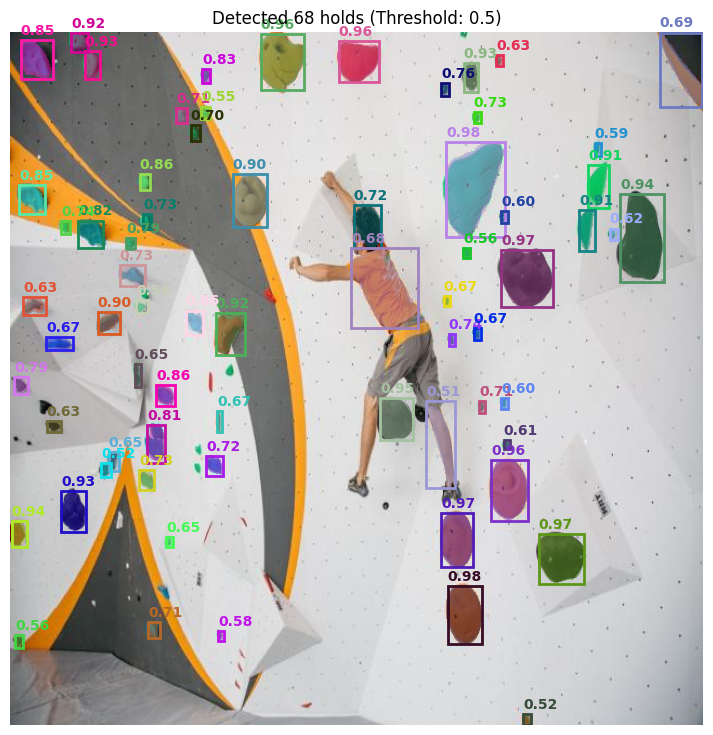

In [24]:
main()